In [1]:
import os
from dataset import OpenImageDataset
from transformers import CLIPTokenizer

clip_tokenizer = CLIPTokenizer.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    subfolder="tokenizer",
)

In [2]:
bg_image_dir = "/export/share/dongxuli/BG59K/images"

split = "train"

dataset = OpenImageDataset(
    split=f"{split}",
    load_cache=True,
    # debug=True,
    # text_transform=lambda x: x,
    clip_tokenizer=clip_tokenizer,
    # simple_prompt=True,
#     min_size=0.30,
#     max_size=0.50,
)

All labels: 291905


In [3]:
len(dataset)

291905

In [4]:
from PIL import Image

image_filenames = os.listdir(bg_image_dir)
image_filenames = [os.path.join(bg_image_dir, img_fn) for img_fn in image_filenames]

def sample_bg_image():
    return Image.open(random.choice(image_filenames)).convert("RGB")

In [60]:
# browse a random sample
import random

i = random.randint(0, len(dataset))

example = dataset[i]

In [61]:
example.keys()

dict_keys(['image', 'input_image', 'target_image', 'bbox_image', 'bbox_image_syn', 'bbox_input_image', 'bbox_target_image', 'bbox_mask', 'caption', 'class_name', 'input_ids', 'ctx_begin_pos', 'input_ids_label', 'ctx_begin_pos_label', 'image_id', 'bbox', 'row'])

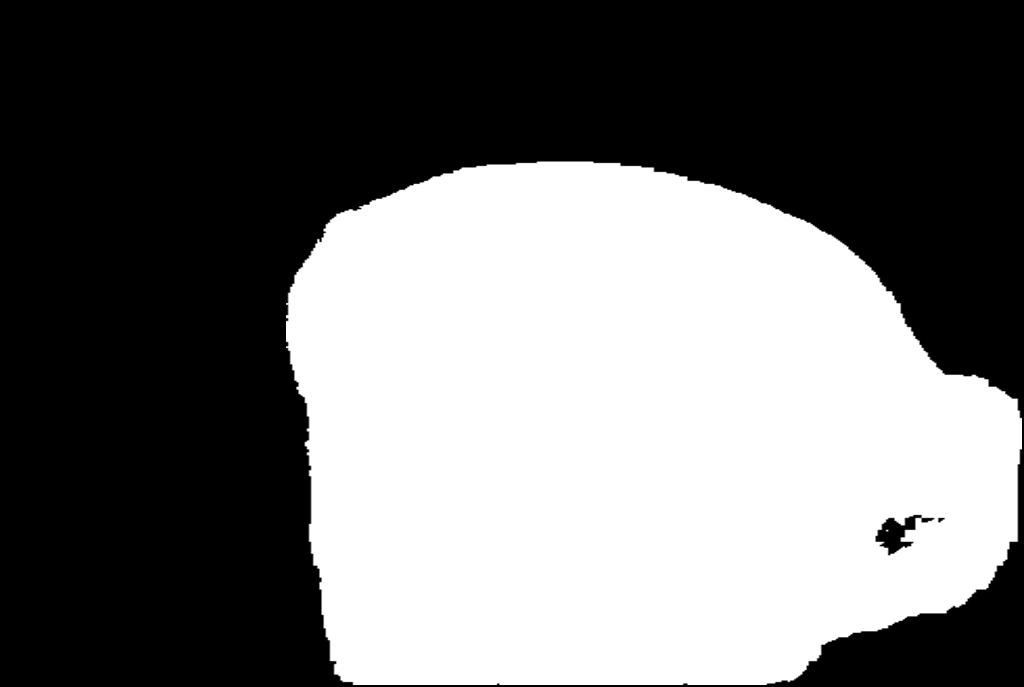

In [62]:
example["bbox_mask"]

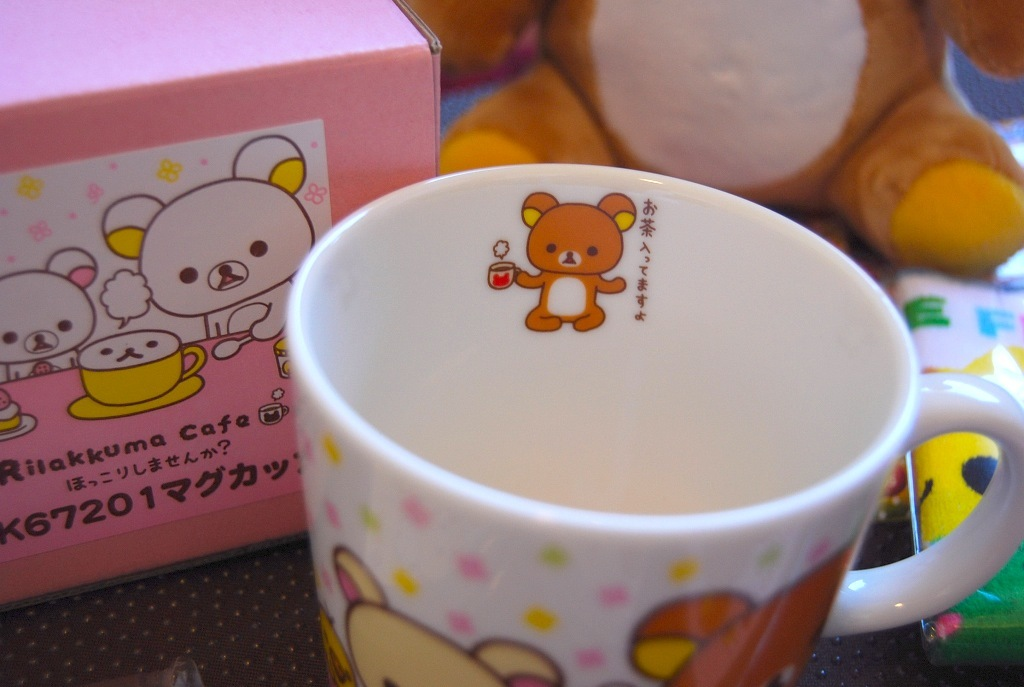

In [63]:
example["image"]

In [64]:
example["caption"]

'there is a bear mug that has some pink decorations, the mug is'

In [65]:
example["image"].size

(1024, 687)

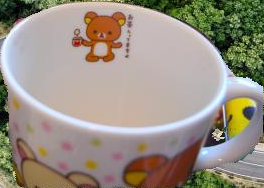

In [66]:
example["bbox_image_syn"]

In [ ]:
len(image_filenames)

In [ ]:
# bg_sample = sample_bg_image()
# display(bg_sample)

In [4]:
from PIL import Image

def resize_image_with_aspect_ratio(image, max_side=368):
    # Determine the new size based on the aspect ratio
    width, height = image.size

    long_side = width if width > height else height
    ratio = max_side / long_side
    
    new_width = int(width * ratio)
    new_height = int(height * ratio)
    
    return image.resize((new_width, new_height)), new_width, new_height
    

def composite(fg_image, mask, bg_image=None):
    mask = mask.convert("1")
    if bg_image is None:
        bg_image = Image.new('RGB', fg_image.size)
    return Image.composite(fg_image, bg_image, mask)

    
def rand_crop_image(image, width, height):
    iw, ih = image.size
    
    if iw < width or ih < height:
        raise ValueError("bg size smaller than bbox size")
        
    left = random.randint(0, iw - width)
    top = random.randint(0, ih - height)
    
    return image.crop((left, top, left+width, top+height))

In [18]:
# fg_image, r_width, r_height = resize_image_with_aspect_ratio(example["image"])
# mask, _, _ = resize_image_with_aspect_ratio(example["bbox_mask"])

# display(fg_image)
# display(mask)

# bg_w, bg_h = bg_sample.size
# bg_sample = rand_crop_image(bg_sample, r_width, r_height)

# composite_image = composite(
#     fg_image=fg_image,
#     mask=mask,
#     bg_image=bg_sample
# )
# display(composite_image)

In [19]:
# example["bbox"]

In [5]:
def crop_bbox(image, bbox, width, height):
    xmin, ymin, xmax, ymax = bbox

    xmin = int(xmin * width)
    xmax = int(xmax * width)
    ymin = int(ymin * height)
    ymax = int(ymax * height)

    xmin = max(0, xmin)
    ymin = max(0, ymin)
    xmax = min(image.width, xmax)
    ymax = min(image.height, ymax)

    return image.crop((xmin, ymin, xmax, ymax))

# c_w, c_h = composite_image.size
# crop_bbox(composite_image, example["bbox"], c_w, c_h)

In [6]:
import random

In [7]:
def synthesize(fg_image, bg_image, mask):
    fg_image, r_width, r_height = resize_image_with_aspect_ratio(fg_image)
    mask, _, _ = resize_image_with_aspect_ratio(mask)
    
    bg_w, bg_h = bg_image.size
    bg_image = rand_crop_image(bg_image, r_width, r_height)

    composite_image = composite(
        fg_image=fg_image,
        mask=mask,
        bg_image=bg_image
    )
    
    return composite_image


def safe_synthesize(example):
    while True:
        try:
            syn_image = synthesize(fg_image=example["image"].convert("RGB"), bg_image=sample_bg_image(), mask=example["bbox_mask"])
        except ValueError:
#             print("invalid")
            syn_image = None

        if syn_image is not None:
            break
            
    return syn_image


# def syn_and_save(example):
#     syn_image = safe_synthesize(example)
    
#     filename = os.path.basename(example["image_path"])
#     outdir = "/export/home/workspace/dreambooth/diffusers/data/openimage-image-syn"
    
#     outpath = os.path.join(outdir, filename)
    
#     syn_image.save(outpath)
    
#     return syn_image
    

In [11]:
# from multiprocessing import Pool
# from tqdm import tqdm

# with Pool() as pool:
#     results = list(tqdm(pool.imap(syn_and_save, dataset), total=len(dataset)))

 38%|█████████████████████████████████████████▉                                                                    | 111158/291905 [1:04:46<1:48:51, 27.67it/s]

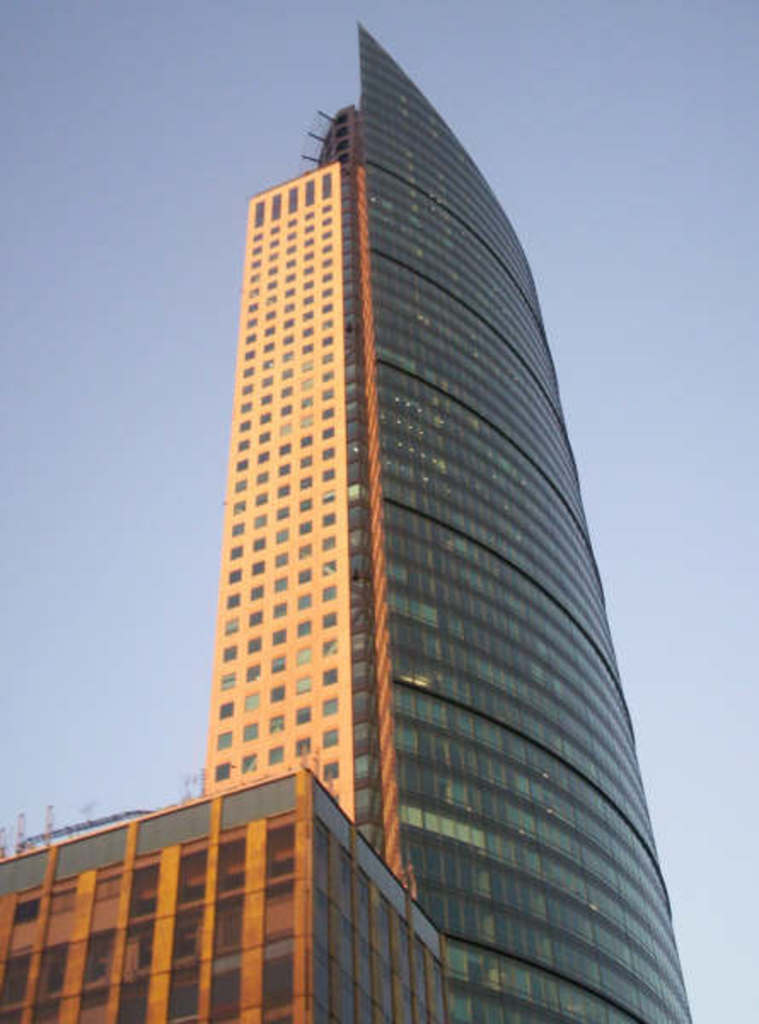

'the building has a tall clock tower, the tower is'

'6c8b95a85e1ccb8a_tower.jpg'

'6c8b95a85e1ccb8a_tower.jpg'

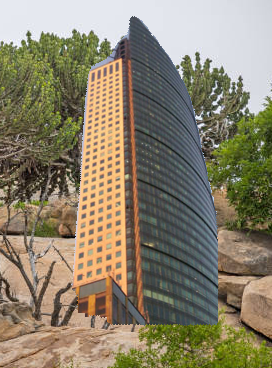

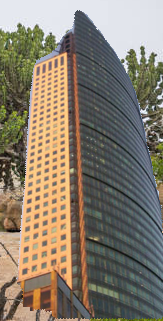

In [10]:
i = random.randint(0, len(dataset))

example = dataset[i]

display(example["image"])
display(example["caption"])
display(example["image_path"])
display(os.path.basename(example["image_path"]))

# syn_image = safe_synthesize(example)
# syn_image = syn_and_save(example)

display(syn_image)
c_w, c_h = syn_image.size
syn_bbox = crop_bbox(syn_image, example["bbox"], c_w, c_h)
display(syn_bbox)

